In [1]:
from keras.datasets import mnist
from keras.datasets import fashion_mnist

from sklearn.decomposition import PCA
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV

import random
import matplotlib
import scipy.stats
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# 导入之前的实验数据
xls_path = 'E:\\Phd\\Research\\Experiments\\0416\\data.xlsx'
x1 = pd.read_excel(xls_path, sheet_name='x1', header=None).to_numpy()
x1_5f = pd.read_excel(xls_path, sheet_name='x1_5f', header=None).to_numpy()

df_res = pd.read_excel(xls_path, sheet_name='res')
res_0 = df_res['res_0'].to_numpy().reshape(-1, 1)

df_label = pd.read_excel(xls_path, sheet_name='label')
label_x1 = df_label['label_x1'].to_numpy()
label_x1_5f = df_label['label_x1_5f'].to_numpy()

ind_r5m = pd.read_excel(xls_path, sheet_name='index').to_numpy().flatten().tolist()

In [3]:
# 加载Fashion-MNIST数据集
(x2_train, y2_train), (x2_test, y2_test) = fashion_mnist.load_data()
x2_all = x2_train.reshape(60000, 784)

### 实验1-2：替换 部分MNIST样本 为 Fashion-MNIST其他样本 
### 实验1-2-1：N=5000，R = 0%， 5%， 40%
* 获取不同替换比例R对应的一维数据分布

In [4]:
"""获得R=0%时x1降维后的一维分布"""
# 使用网格搜索交叉验证来优化带宽
params_0 = {'bandwidth': np.logspace(-1, 3, 40)}
grid_0 = GridSearchCV(KernelDensity(), params_0)
grid_0.fit(res_0)
print("best bandwidth 1d: {0}".format(grid_0.best_estimator_.bandwidth))

# 使用最佳估计器来计算核密度估计
kde_0 = grid_0.best_estimator_

best bandwidth 1d: 46.41588833612777


In [5]:
"""获得R=40%时x1降维后的一维分布"""
ind_5f = list(filter(lambda x: x not in ind_r5m, range(5000))) # x1_5f中原始元素对应x1中的索引
ind_a40f = random.sample(ind_5f, int(0.35*len(x1))) # x1_40f相对x1_5f新增被替换元素对应x1中的索引
ind_r40f = ind_r5m + ind_a40f # x1_40f中所有被替换的元素对应x1中的索引
x1_40f = x1_5f
x1_40f[ind_a40f] = x2_all[len(ind_r5m):len(ind_r40f)]

pca_40f = PCA(n_components=1, whiten=False)
res_40f = pca_40f.fit_transform(x1_40f)

# 使用网格搜索交叉验证来优化带宽
params_40f = {'bandwidth': np.logspace(-1, 3, 40)}
grid_40f = GridSearchCV(KernelDensity(), params_40f)
grid_40f.fit(res_40f)
print("best bandwidth 1d: {0}".format(grid_40f.best_estimator_.bandwidth))

# 使用最佳估计器来计算核密度估计
kde_40f = grid_40f.best_estimator_

best bandwidth 1d: 46.41588833612777


#### a) 不同一维分布的可视化对比

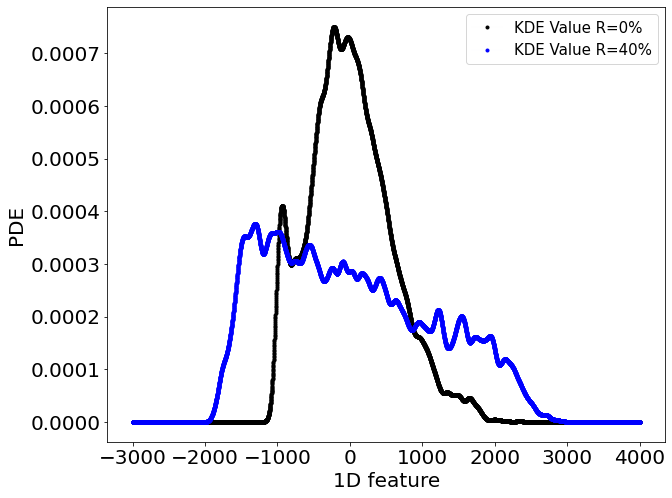

In [6]:
xplot = np.linspace(-3000, 4000, 7000).reshape(-1,1)
dens_0 = kde_0.score_samples(xplot)  # 返回的是点对应概率密度的log值，需要使用exp求指数还原
dens_40f = kde_40f.score_samples(xplot)

plt.figure(figsize = (10, 8))  # 设置画布大小
plt.plot(xplot, np.exp(dens_0), marker='.', linewidth=0.01, c="k", label='KDE Value R=0%')
plt.plot(xplot, np.exp(dens_40f), marker='.', linewidth=0.01, c="b", label='KDE Value R=40%')
plt.tick_params(labelsize = 20)  # 设置坐标刻度值的大小
font = {'size': 20}  # 设置横纵坐标的名称以及对应字体格式、大小
plt.xlabel('1D feature', font)
plt.ylabel('PDE', font)
plt.legend(fontsize = 15)  # 显示图例,设置图例字体大小
plt.show()

#### b) 1D特征区间\[-1000, -500\]和\[0, 500\]对应样本数据的对比（R = 0% vs 40%）

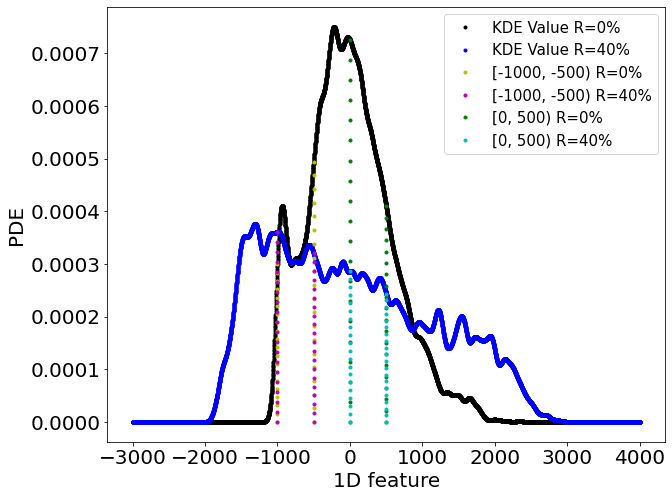

In [7]:
"""可视化所选取的区间"""
plt.figure(figsize = (10, 8))  # 设置画布大小
plt.plot(xplot, np.exp(dens_0), marker='.', linewidth=1e-10, c="k", label='KDE Value R=0%')
plt.plot(xplot, np.exp(dens_40f), marker='.', linewidth=1e-10, c="b", label='KDE Value R=40%')

# [-1000, -500)区间
px_0_int = [-1000] * 20 + [-500] * 20
py_0_int = list(np.linspace(0, np.exp(kde_0.score_samples([[-1000]])[0]), 20)) + list(np.linspace(0, np.exp(kde_0.score_samples([[-500]])[0]), 20))

px_40f_int = [-1000] * 20 + [-500] * 20
py_40f_int = list(np.linspace(0, np.exp(kde_40f.score_samples([[-1000]])[0]), 20)) + list(np.linspace(0, np.exp(kde_40f.score_samples([[-500]])[0]), 20))

plt.plot(px_0_int, py_0_int, marker='.', linewidth=1e-5, c="y", label='[-1000, -500) R=0%')
plt.plot(px_40f_int, py_40f_int, marker='.', linewidth=1e-5, c="m", label='[-1000, -500) R=40%')

# [0, 500)区间
px_0_int1 = [0] * 20 + [500] * 20
py_0_int1 = list(np.linspace(0, np.exp(kde_0.score_samples([[0]])[0]), 20)) + list(np.linspace(0, np.exp(kde_0.score_samples([[500]])[0]), 20))

px_40f_int1 = [0] * 20 + [500] * 20
py_40f_int1 = list(np.linspace(0, np.exp(kde_40f.score_samples([[0]])[0]), 20)) + list(np.linspace(0, np.exp(kde_40f.score_samples([[500]])[0]), 20))

plt.plot(px_0_int1, py_0_int1, marker='.', linewidth=1e-5, c="g", label='[0, 500) R=0%')
plt.plot(px_40f_int1, py_40f_int1, marker='.', linewidth=1e-5, c="c", label='[0, 500) R=40%')


plt.tick_params(labelsize = 20)  # 设置坐标刻度值的大小
font = {'size': 20}  # 设置横纵坐标的名称以及对应字体格式、大小
plt.xlabel('1D feature', font)
plt.ylabel('PDE', font)
plt.legend(fontsize = 15)  # 显示图例,设置图例字体大小
plt.show()

##### \[-1000, -500)对应样本数据的对比（R = 0% vs 40%）
* 计算打印分析统计数据

In [8]:
"""R=0%时[-1000, -500)对应的样本类别统计"""
ind_int = np.array([i for (i,x) in enumerate(res_0.flatten().tolist()) if -1000 <= x < -500]) #在x1中的索引
num_int = ind_int.shape[0]
label_int_m = label_x1[ind_int]
num_int_m0 = label_int_m.tolist().count(0)
num_int_m1 = label_int_m.tolist().count(1)
num_int_m2 = label_int_m.tolist().count(2)
num_int_m3 = label_int_m.tolist().count(3)
num_int_m4 = label_int_m.tolist().count(4)
num_int_m5 = label_int_m.tolist().count(5)
num_int_m6 = label_int_m.tolist().count(6)
num_int_m7 = label_int_m.tolist().count(7)
num_int_m8 = label_int_m.tolist().count(8)
num_int_m9 = label_int_m.tolist().count(9)

In [9]:
"""R=40%时被替换掉的[-1000, -500)样本对应的样本类别统计"""
ind_int_r40 = np.array([i for (i,x) in enumerate(res_0[ind_r40f].flatten().tolist()) if -1000 <= x < -500]) #所求样本在ind_r40f索引对应数组切片中的索引
ind_int_r40m = np.array(ind_r40f)[ind_int_r40] # 对应在x1中的索引
num_int_r40 = ind_int_r40m.shape[0]
label_int_r40 = label_x1[ind_int_r40m]
num_int_r40m0 = label_int_r40.tolist().count(0)
num_int_r40m1 = label_int_r40.tolist().count(1)
num_int_r40m2 = label_int_r40.tolist().count(2)
num_int_r40m3 = label_int_r40.tolist().count(3)
num_int_r40m4 = label_int_r40.tolist().count(4)
num_int_r40m5 = label_int_r40.tolist().count(5)
num_int_r40m6 = label_int_r40.tolist().count(6)
num_int_r40m7 = label_int_r40.tolist().count(7)
num_int_r40m8 = label_int_r40.tolist().count(8)
num_int_r40m9 = label_int_r40.tolist().count(9)

In [10]:
"""R=40%时新添的[-1000, -500]中样本对应的样本类别统计"""
ind_int_r40f = np.array([i for (i,x) in enumerate(res_40f[ind_r40f].flatten().tolist()) if -1000 <= x < -500]) # 在ind_r40f数组切片上的索引
num_int_r40f = ind_int_r40f.shape[0]
label_int_r40f = y2_train[ind_int_r40f]
num_int_r40f0 = label_int_r40f.tolist().count(0)
num_int_r40f1 = label_int_r40f.tolist().count(1)
num_int_r40f2 = label_int_r40f.tolist().count(2)
num_int_r40f3 = label_int_r40f.tolist().count(3)
num_int_r40f4 = label_int_r40f.tolist().count(4)
num_int_r40f5 = label_int_r40f.tolist().count(5)
num_int_r40f6 = label_int_r40f.tolist().count(6)
num_int_r40f7 = label_int_r40f.tolist().count(7)
num_int_r40f8 = label_int_r40f.tolist().count(8)
num_int_r40f9 = label_int_r40f.tolist().count(9)

In [11]:
# [-1000, -500)中总样本统计
print(num_int, num_int_m0, num_int_m1, num_int_m2, num_int_m3, num_int_m4, num_int_m5, num_int_m6, num_int_m7, num_int_m8, num_int_m9)
# [-1000, -500)中被替换样本统计
print(num_int_r40, num_int_r40m0, num_int_r40m1, num_int_r40m2, num_int_r40m3, num_int_r40m4, num_int_r40m5, num_int_r40m6, num_int_r40m7, num_int_r40m8, num_int_r40m9)
# [-1000, -500)中FASHION替换样本统计
print(num_int_r40f, num_int_r40f0, num_int_r40f1, num_int_r40f2, num_int_r40f3, num_int_r40f4, num_int_r40f5, num_int_r40f6, num_int_r40f7, num_int_r40f8, num_int_r40f9)

902 5 476 46 31 52 31 26 123 29 83
373 5 181 28 19 25 11 15 50 10 29
257 22 21 20 23 7 21 18 33 23 69


* 可视化样本类别变化

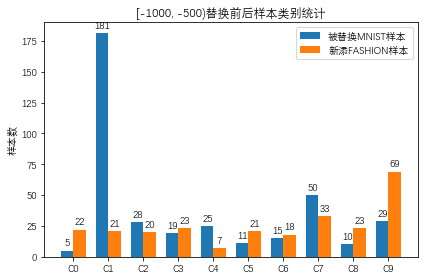

In [12]:
matplotlib.rcParams['font.family']=["DengXian", "sans-serif"]

labels = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9']
mnist_means = [num_int_r40m0, num_int_r40m1, num_int_r40m2, num_int_r40m3, num_int_r40m4, num_int_r40m5, num_int_r40m6, num_int_r40m7, num_int_r40m8, num_int_r40m9]
fashion_means = [num_int_r40f0, num_int_r40f1, num_int_r40f2, num_int_r40f3, num_int_r40f4, num_int_r40f5, num_int_r40f6, num_int_r40f7, num_int_r40f8, num_int_r40f9]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()

rects2 = ax.bar(x - width/2, mnist_means, width, label='被替换MNIST样本')
rects3 = ax.bar(x + width/2, fashion_means, width, label='新添FASHION样本')

ax.set_ylabel('样本数')
ax.set_title('[-1000, -500)替换前后样本类别统计')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects2)
autolabel(rects3)

fig.tight_layout()

##### \[0, 500)对应样本数据的对比（R = 0% vs 40%）
* 计算打印分析统计数据

In [13]:
"""R=0%时[0, 500)对应的样本类别统计"""
ind_int1 = np.array([i for (i,x) in enumerate(res_0.flatten().tolist()) if 0 <= x < 500])
num_int1_m = ind_int1.shape[0]
label_int1_m = label_x1[ind_int1]
num_int1_m0 = label_int1_m.tolist().count(0)
num_int1_m1 = label_int1_m.tolist().count(1)
num_int1_m2 = label_int1_m.tolist().count(2)
num_int1_m3 = label_int1_m.tolist().count(3)
num_int1_m4 = label_int1_m.tolist().count(4)
num_int1_m5 = label_int1_m.tolist().count(5)
num_int1_m6 = label_int1_m.tolist().count(6)
num_int1_m7 = label_int1_m.tolist().count(7)
num_int1_m8 = label_int1_m.tolist().count(8)
num_int1_m9 = label_int1_m.tolist().count(9)

In [14]:
"""R=40%时被替换掉的[0, 500)样本对应的样本类别统计"""
ind_int1_r40 = np.array([i for (i,x) in enumerate(res_0[ind_r40f].flatten().tolist()) if 0 <= x < 500]) # 所求样本在ind_r40f索引对应数组切片中的索引
num_int1_r40 = ind_int1_r40.shape[0]
label_int1_r40 = label_x1[ind_int1_r40]
num_int1_r40m0 = label_int1_r40.tolist().count(0)
num_int1_r40m1 = label_int1_r40.tolist().count(1)
num_int1_r40m2 = label_int1_r40.tolist().count(2)
num_int1_r40m3 = label_int1_r40.tolist().count(3)
num_int1_r40m4 = label_int1_r40.tolist().count(4)
num_int1_r40m5 = label_int1_r40.tolist().count(5)
num_int1_r40m6 = label_int1_r40.tolist().count(6)
num_int1_r40m7 = label_int1_r40.tolist().count(7)
num_int1_r40m8 = label_int1_r40.tolist().count(8)
num_int1_r40m9 = label_int1_r40.tolist().count(9)

In [15]:
"""R=40%时新添的[0, 500]中样本对应的样本类别统计"""
ind_int1_r40f = np.array([i for (i,x) in enumerate(res_40f[ind_r40f].flatten().tolist()) if 0 <= x < 500]) # 在ind_r40f数组切片上的索引
num_int1_r40f = ind_int1_r40f.shape[0]
label_int1_r40f = y2_train[ind_int1_r40f]
num_int1_r40f0 = label_int1_r40f.tolist().count(0)
num_int1_r40f1 = label_int1_r40f.tolist().count(1)
num_int1_r40f2 = label_int1_r40f.tolist().count(2)
num_int1_r40f3 = label_int1_r40f.tolist().count(3)
num_int1_r40f4 = label_int1_r40f.tolist().count(4)
num_int1_r40f5 = label_int1_r40f.tolist().count(5)
num_int1_r40f6 = label_int1_r40f.tolist().count(6)
num_int1_r40f7 = label_int1_r40f.tolist().count(7)
num_int1_r40f8 = label_int1_r40f.tolist().count(8)
num_int1_r40f9 = label_int1_r40f.tolist().count(9)

In [16]:
# [0, 500)中总样本统计
print(num_int1_m, num_int1_m0, num_int1_m1, num_int1_m2, num_int1_m3, num_int1_m4, num_int1_m5, num_int1_m6, num_int1_m7, num_int1_m8, num_int1_m9)
# [0, 500)中被替换样本统计
print(num_int1_r40, num_int1_r40m0, num_int1_r40m1, num_int1_r40m2, num_int1_r40m3, num_int1_r40m4, num_int1_r40m5, num_int1_r40m6, num_int1_r40m7, num_int1_r40m8, num_int1_r40m9)
# [0, 500)中FASHION替换样本统计
print(num_int1_r40f, num_int1_r40f0, num_int1_r40f1, num_int1_r40f2, num_int1_r40f3, num_int1_r40f4, num_int1_r40f5, num_int1_r40f6, num_int1_r40f7, num_int1_r40f8, num_int1_r40f9)

1454 75 11 178 201 168 202 223 104 151 141
581 63 57 58 47 56 71 65 60 53 51
310 28 87 22 40 14 2 20 0 53 44


* 可视化样本类别变化

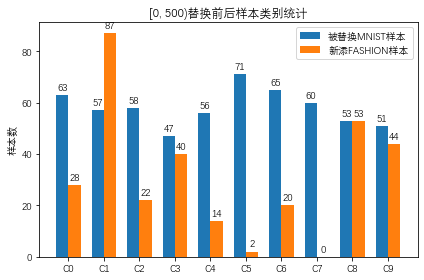

In [17]:
matplotlib.rcParams['font.family']=["DengXian", "sans-serif"]

labels = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9']
mnist_means_int1 = [num_int1_r40m0, num_int1_r40m1, num_int1_r40m2, num_int1_r40m3, num_int1_r40m4, num_int1_r40m5, num_int1_r40m6, num_int1_r40m7, num_int1_r40m8, num_int1_r40m9]
fashion_means_int1 = [num_int1_r40f0, num_int1_r40f1, num_int1_r40f2, num_int1_r40f3, num_int1_r40f4, num_int1_r40f5, num_int1_r40f6, num_int1_r40f7, num_int1_r40f8, num_int1_r40f9]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig_int1, ax_int1 = plt.subplots()

rects2_int1 = ax_int1.bar(x - width/2, mnist_means_int1, width, label='被替换MNIST样本')
rects3_int1 = ax_int1.bar(x + width/2, fashion_means_int1, width, label='新添FASHION样本')

ax_int1.set_ylabel('样本数')
ax_int1.set_title('[0, 500)替换前后样本类别统计')
ax_int1.set_xticks(x)
ax_int1.set_xticklabels(labels)
ax_int1.legend()

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax_int1.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects2_int1)
autolabel(rects3_int1)

fig_int1.tight_layout()

* 样本特征值

In [18]:
# [-1000, -500)中被替换样本特征值
data_int_r40m = res_0[np.array(ind_r40f)[ind_int_r40]]
# [-1000, -500)中FASHION替换样本特征值
data_int_r40f = res_40f[np.array(ind_r40f)[ind_int_r40f]]

# [0, 500)中被替换样本特征值
data_int1_r40m = res_0[np.array(ind_r40f)[ind_int1_r40]]
# [0, 500)中FASHION替换样本特征值
data_int1_r40f = res_40f[np.array(ind_r40f)[ind_int1_r40f]]

* 计算可视化KL散度

In [19]:
# [-1000, -500)区间
xplot_int = np.linspace(-1000, -500, 500).reshape(-1,1)
dens_0_int = kde_0.score_samples(xplot_int) 
dens_40_int = kde_40f.score_samples(xplot_int) 

# [0, 500)区间
xplot_int1 = np.linspace(0, 500, 500).reshape(-1,1)
dens_0_int1 = kde_0.score_samples(xplot_int1)
dens_40_int1 = kde_40f.score_samples(xplot_int1)

# [-1500, -1000)区间
xplot_int2 = np.linspace(-1500, -1000, 500).reshape(-1,1)
dens_0_int2 = kde_0.score_samples(xplot_int2) 
dens_40_int2 = kde_40f.score_samples(xplot_int2) 

# [-500, 0)区间
xplot_int3 = np.linspace(-500, 0, 500).reshape(-1,1)
dens_0_int3 = kde_0.score_samples(xplot_int3)
dens_40_int3 = kde_40f.score_samples(xplot_int3)

# [500, 1000)区间
xplot_int4 = np.linspace(500, 1000, 500).reshape(-1,1)
dens_0_int4 = kde_0.score_samples(xplot_int4) 
dens_40_int4 = kde_40f.score_samples(xplot_int4) 

# [1000, 1500)区间
xplot_int5 = np.linspace(1000, 1500, 500).reshape(-1,1)
dens_0_int5 = kde_0.score_samples(xplot_int5)
dens_40_int5 = kde_40f.score_samples(xplot_int5)

# [1500, 2000)区间
xplot_int6 = np.linspace(1500, 2000, 500).reshape(-1,1)
dens_0_int6 = kde_0.score_samples(xplot_int6)
dens_40_int6 = kde_40f.score_samples(xplot_int6)

# [2000, 2500)区间
xplot_int7 = np.linspace(2000, 2500, 500).reshape(-1,1)
dens_0_int7 = kde_0.score_samples(xplot_int7)
dens_40_int7 = kde_40f.score_samples(xplot_int7)

# [2500, 3000)区间
xplot_int8 = np.linspace(2500, 3000, 500).reshape(-1,1)
dens_0_int8 = kde_0.score_samples(xplot_int8) 
dens_40_int8 = kde_40f.score_samples(xplot_int8) 

# [3000, 3500)区间
xplot_int9 = np.linspace(3000, 3500, 500).reshape(-1,1)
dens_0_int9 = kde_0.score_samples(xplot_int9)
dens_40_int9 = kde_40f.score_samples(xplot_int9)

In [20]:
KL_int  = scipy.stats.entropy(np.exp(dens_0_int), np.exp(dens_40_int))
KL_int1 = scipy.stats.entropy(np.exp(dens_0_int1), np.exp(dens_40_int1))
KL_int2 = scipy.stats.entropy(np.exp(dens_0_int2), np.exp(dens_40_int2))
KL_int3 = scipy.stats.entropy(np.exp(dens_0_int3), np.exp(dens_40_int3))
KL_int4 = scipy.stats.entropy(np.exp(dens_0_int4), np.exp(dens_40_int4))
KL_int5 = scipy.stats.entropy(np.exp(dens_0_int5), np.exp(dens_40_int5))
KL_int6 = scipy.stats.entropy(np.exp(dens_0_int6), np.exp(dens_40_int6))
KL_int7 = scipy.stats.entropy(np.exp(dens_0_int7), np.exp(dens_40_int7))
KL_int8 = scipy.stats.entropy(np.exp(dens_0_int8), np.exp(dens_40_int8))
KL_int9 = scipy.stats.entropy(np.exp(dens_0_int9), np.exp(dens_40_int9))

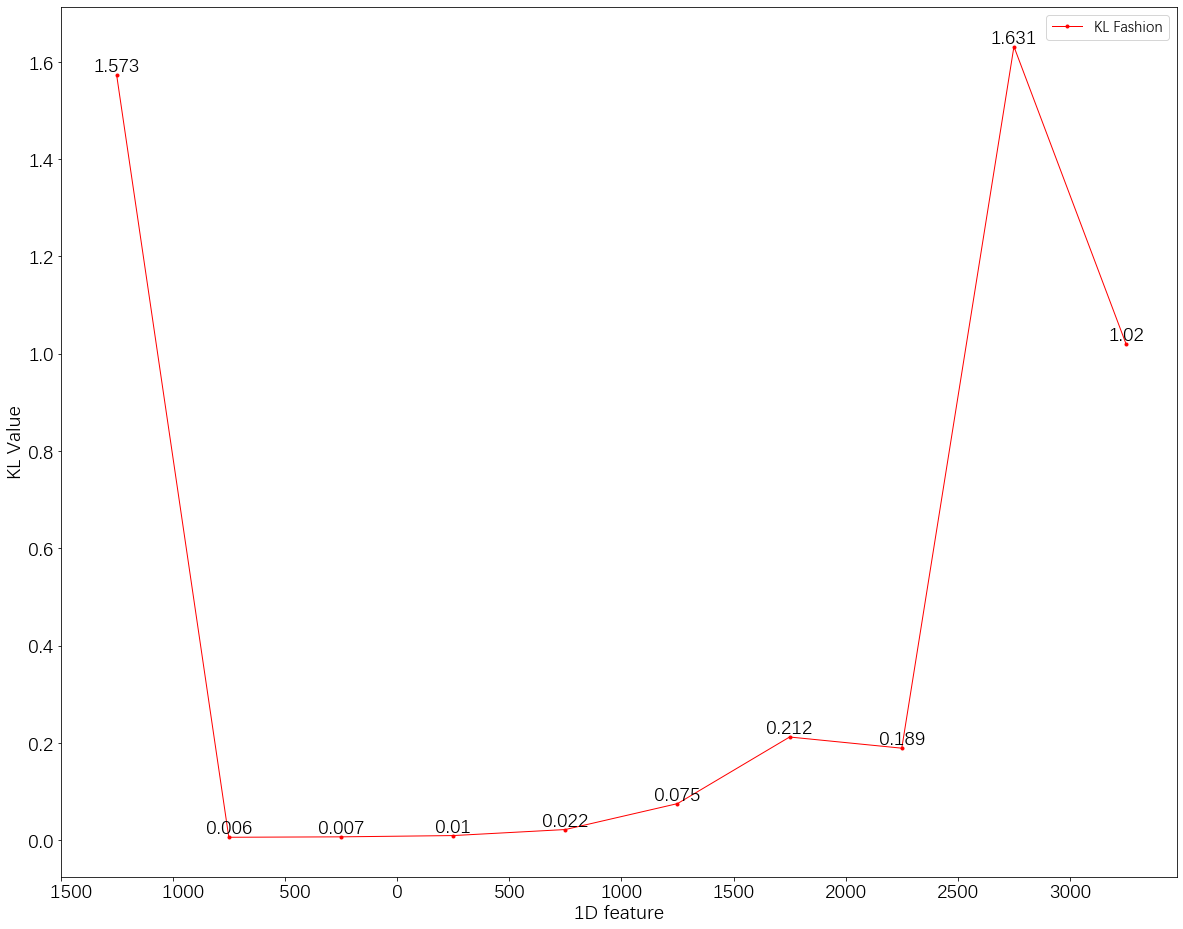

In [22]:
"""可视化KL散度折线图"""
xplot_KL = [-1250, -750, -250, 250, 750, 1250, 1750, 2250, 2750, 3250]
KL_f = [KL_int2, KL_int, KL_int3, KL_int1, KL_int4, KL_int5, KL_int6, KL_int7, KL_int8, KL_int9]

plt.figure(figsize = (20, 16))  # 设置画布大小
plt.plot(xplot_KL, KL_f, marker='.', linewidth=1, c="r", label='KL Fashion')

for c, d in zip(xplot_KL, KL_f):
    plt.text(c, d, (float('%.3f'%d)), ha='center', va='bottom', fontsize=20)

plt.xticks(np.arange(-1500, 3500, step=500))
plt.tick_params(labelsize = 20)  # 设置坐标刻度值的大小
font = {'size': 20}  # 设置横纵坐标的名称以及对应字体格式、大小
plt.xlabel('1D feature', font)
plt.ylabel('KL Value', font)
plt.legend(fontsize = 15)  # 显示图例,设置图例字体大小
plt.show()

* 输出保存相关数据用于后续分析

In [23]:
df_x1 = pd.DataFrame(x1)
df_x1_40f = pd.DataFrame(x1_40f)
res = pd.DataFrame({'res_0':res_0.squeeze(), 'res_40f':res_40f.squeeze()})
label_x1_40f = label_x1
label_x1_40f[ind_r40f] = y2_train[:len(ind_r40f)]
label = pd.DataFrame({'label_x1':label_x1, 'label_x1_40f':label_x1_40f})
index = pd.DataFrame({'ind_r40f':ind_r40f})

In [24]:
xls_path = 'E:\\Phd\\Research\\Experiments\\0422\\random\\data.xlsx'

with pd.ExcelWriter(xls_path) as writer:
    df_x1.to_excel(writer, sheet_name='x1', header=False, index=False)
    df_x1_40f.to_excel(writer, sheet_name='x1_40f', header=False, index=False)
    res.to_excel(writer, sheet_name='res', index=False)
    label.to_excel(writer, sheet_name='label', index=False)
    index.to_excel(writer, sheet_name='index', index=False)
    writer.save()